<a href="https://colab.research.google.com/github/jmbaek/ImageCNN/blob/main/plantDisease_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!git clone https://github.com/spMohanty/PlantVillage-Dataset.git

Cloning into 'PlantVillage-Dataset'...
remote: Enumerating objects: 163229, done.
remote: Total 163229 (delta 0), reused 0 (delta 0), pack-reused 163229
Receiving objects: 100% (163229/163229), 2.00 GiB | 13.91 MiB/s, done.
Resolving deltas: 100% (99/99), done.
Checking out files: 100% (182401/182401), done.


In [67]:
!mkdir -p data
!mv PlantVillage-Dataset/data_distribution_for_SVM/test/ data/test/
!mv PlantVillage-Dataset/data_distribution_for_SVM/train/ data/train/

mv: cannot stat 'PlantVillage-Dataset/data_distribution_for_SVM/test/': No such file or directory
mv: cannot stat 'PlantVillage-Dataset/data_distribution_for_SVM/train/': No such file or directory


In [68]:
train_data_dir = "data/train/"
validation_data_dir = "data/test/"

In [90]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
from google.colab import files
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNetV2 #14 MB acc Top1 0.71 top5 0.9
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D , Dropout

In [100]:
####### SCRIPT TO DOWNLOAD KAGGLE DATASET IN GOOGLE COLAB ######### .
from google.colab import files
#Upload your kaggle.json file 
#files.upload()

!mkdir -p  ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#Copy the API command from kaggle .
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

#Unzip dataset ,always with -q (quiet)
!unzip -q /content/new-plant-diseases-dataset.zip

100% 2.70G/2.70G [01:13<00:00, 48.0MB/s]
100% 2.70G/2.70G [01:13<00:00, 39.2MB/s]


In [101]:
#Necessary data preparation.
def data_prep():
    #Apply data augmentation on-the-fly on the training set to increase generalizability of the model.
    train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255,
                                                                shear_range = 0.2,
                                                                zoom_range = 0.2,
                                                                width_shift_range = 0.2,
                                                                height_shift_range = 0.2,
                                                                fill_mode="nearest")
    #Create the pipeline
    train_data = train_datagen.flow_from_directory(os.path.join(PATH,"train"),
                                                  target_size=(image_size,image_size),
                                                  batch_size=BATCH_SIZE,
                                                  class_mode="categorical")
    # Normalize validation dataset's image rgb values.
    valid_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255)
    #Create the pipeline
    valid_data = valid_datagen.flow_from_directory(os.path.join(PATH,"valid"),
                                                  target_size=(image_size,image_size),
                                                  batch_size=BATCH_SIZE,
                                                  class_mode="categorical")
    return[train_data,valid_data]

In [102]:
#Plot training learning curves for both train and validation.
def plot_training_curves(history):
        #Defining the metrics we will plot.
        train_acc=history.history['accuracy']
        val_acc=history.history['val_accuracy']
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        
        #Range for the X axis.
        epochs = range(len(train_loss))
        
        #Plotting Loss figures.
        fig = plt.figure(figsize=(10,6)) #figure size h,w in inches 
        plt.rcParams.update({'font.size': 22}) #configuring font size.
        plt.plot(epochs,train_loss,c="red",label="Training Loss") #plotting
        plt.plot(epochs,val_loss,c="blue",label="Validation Loss")
        plt.xlabel("Epochs") #title for x axis
        plt.ylabel("Loss")   #title for y axis
        plt.legend()

        #Plotting Accuracy figures. 
        fig = plt.figure(figsize=(10,6)) #figure size h,w in inches
        plt.plot(epochs,train_acc,c="red",label="Training Acc") #plotting
        plt.plot(epochs,val_acc,c="blue",label="Validation Acc")
        plt.xlabel("Epochs")   #title for x axis
        plt.ylabel("Accuracy") #title for y axis
        plt.legend()

In [103]:
#Make predictions on manually created test dataset folder. (OPTIONAL, different to initial dataset test set)
def test_model(path):
    i=0
    #Inversing class dictionary [keys,values]->[values,keys]
    labels = (train_data.class_indices)
    labels = dict((v,k) for k,v in labels.items())

    for filename in os.listdir(path) :
        i+=1
        file_path= path +"/" + str(pathlib.Path(filename))
      
        image = tf.keras.preprocessing.image.load_img(
                file_path,grayscale=False, color_mode="rgb",
                target_size=(image_size,image_size), interpolation="nearest")
        input_arr = keras.preprocessing.image.img_to_array(image)
        input_arr=input_arr/255
        input_arr = np.array([input_arr])  # Convert single image to a batch.
        prediction = model.predict(input_arr)


        a=np.argmax(prediction)
        results = labels[a] 

        
        print("\n")
      # print("Predicted class number :", np.argmax(prediction))
        print("Actual class :" ,pathlib.Path(filename))
        print("predicted class name->  MobileV2:",results )
        

    print("\n Tested: " ,i, "new unseen images")

In [104]:
def assign_callbacks(weights_file,patience,lr_factor):
  return[
      #Only save the weights that correspond to the minimum validation loss.
      tf.keras.callbacks.ModelCheckpoint(filepath=weights_file,
                                         monitor='val_accuracy',
                                         mode='max',
                                         save_best_only=True ,
                                         save_weights_only=True,
                                         verbose=0),
      #If val_loss doesn't improve for a number of epochs set with 'patience' 
      #variable, training will stop to avoid overfitting.    
      tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                       mode='min',
                                       patience=patience,
                                       verbose=1),
      #Learning rate is reduced by 'lr_factor' if val_loss stagnates
      #for a number of epochs set with 'patience/2' variable.
      tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                           mode='min',
                                           factor=lr_factor,
                                           patience=patience//2,
                                           min_lr=1e-6,
                                           verbose=1)]

In [105]:
EPOCHS=100 #Number of epochs to train the model.
BATCH_SIZE =32  
PATIENCE=EPOCHS//5
LR_FACTOR=0.2
WEIGHTS_FILE = "weights.h5" #File that stores updated weights
image_size =224 #needs to comply with CNN input constraints. 
PATH="/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)" #Path to dataset
TEST_PATH='/content/test/test'

In [106]:
#The training class names.
class_names=["Apple___Apple_scab","Apple___Black_rot","Apple___Cedar_apple_rust","Apple___healthy",
             "Blueberry___healthy","Cherry_(including_sour)__Powedery_mildew","Cherry_(including_sour)__healthy",
             "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot","Corn_(maize)___Common_rust_","Corn_(maize)___Northern_Leaf_Blight",
             "Corn_(maize)___healthy","Grape___Black_rot","Grape___Esca_(Black_Measles)","Grape___Leaf_blight_(Isariopsis_Leaf_Spot)",
             "Grape___healthy","Orange___Haunglongbing_(Citrus_greening)","Peach___Bacterial_spot","Peach___healthy",
             "Pepper,_bell___Bacterial_spot","Pepper,_bell___healthy","Potato___Early_blight","Potato___Late_blight",
             "Potato___healthy","Raspberry___healthy","Soybean___healthy","Squash___Powdery_mildew",
             "Strawberry___Leaf_scorch","Strawberry___Healthy","Tomato___Bacterial_spot","Tomato___Early_blight","Tomato___Late_blight",
             "Tomato___Leaf_Mold","Tomato___Septoria_leaf_spot","Tomato___Spider_mites Two-spotted_spider_mite",
             "Tomato___Target_Spot","Tomato_Yellow_Leaf_Curl_Virus","Tomato_mosaic_virus","Tomato___healthy"]

In [107]:
#Create the whole neural network, pass the base model as parameter.
def create_model(base_model):
      x = base_model.output
      #Add a global spatial average pooling layer.
      x = GlobalAveragePooling2D()(x)
      #Add a fully-connected layer.
      x = Dense(1024, activation='relu')(x)
      #Add a dropout layer to decrease overfitting
      x=Dropout(0.2)(x)
      #Add a logistic layer with number_of_neurons=number_of_training_classes.
      predictions = Dense(38, activation='softmax')(x)

      #This is the model we will train
      model = Model(inputs=base_model.input, outputs=predictions 
                                      ,name="Plant_Disease_Detector")

      #Freeze layers of the base model, we will only train the extra layers.
      #This way features already learned by the base model aren't lost.
      for layer in base_model.layers:
          layer.trainable = False

      #Assign a base learning rate for the Adam optimizer.
      base_learning_rate = 0.0001
      model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate)
                    ,loss='categorical_crossentropy' ,metrics='accuracy')
      
      return model

In [108]:
#Prepare data
train_data,valid_data=data_prep()
#Define callbacks for training
callbacks=assign_callbacks(WEIGHTS_FILE,PATIENCE,LR_FACTOR)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [109]:
#Create the base pre-trained model, without the classification layers. 
base_model = MobileNetV2(weights='imagenet',
                        include_top=False ,input_shape=(224,224,3))
#Create the complete new model.
model=create_model(base_model)

9420800/9406464 [==============================] - 0s 0us/step


In [110]:
#Information about the model's layers.
model.summary()

Model: "Plant_Disease_Detector"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                            

In [ ]:
#Train the model on the dataset.
history=model.fit(x=train_data , batch_size=BATCH_SIZE,
                 epochs=EPOCHS , verbose=2 ,
                 validation_data=valid_data,
                 steps_per_epoch=20,
                 validation_steps=10,
                 callbacks=callbacks) 


Epoch 1/100
20/20 - 11s - loss: 3.7211 - accuracy: 0.0703 - val_loss: 3.2597 - val_accuracy: 0.1844 - lr: 1.0000e-04 - 11s/epoch - 530ms/step
Epoch 2/100
20/20 - 8s - loss: 3.1617 - accuracy: 0.1719 - val_loss: 2.8576 - val_accuracy: 0.3594 - lr: 1.0000e-04 - 8s/epoch - 378ms/step
Epoch 3/100
20/20 - 8s - loss: 2.6902 - accuracy: 0.3547 - val_loss: 2.4775 - val_accuracy: 0.4062 - lr: 1.0000e-04 - 8s/epoch - 381ms/step
Epoch 4/100
20/20 - 8s - loss: 2.3122 - accuracy: 0.4703 - val_loss: 2.0956 - val_accuracy: 0.5312 - lr: 1.0000e-04 - 8s/epoch - 385ms/step
Epoch 5/100
20/20 - 8s - loss: 2.1154 - accuracy: 0.4812 - val_loss: 1.9426 - val_accuracy: 0.5844 - lr: 1.0000e-04 - 8s/epoch - 377ms/step
Epoch 6/100


In [ ]:
#Plot the Learning Curves from model training.
plot_training_curves(history)

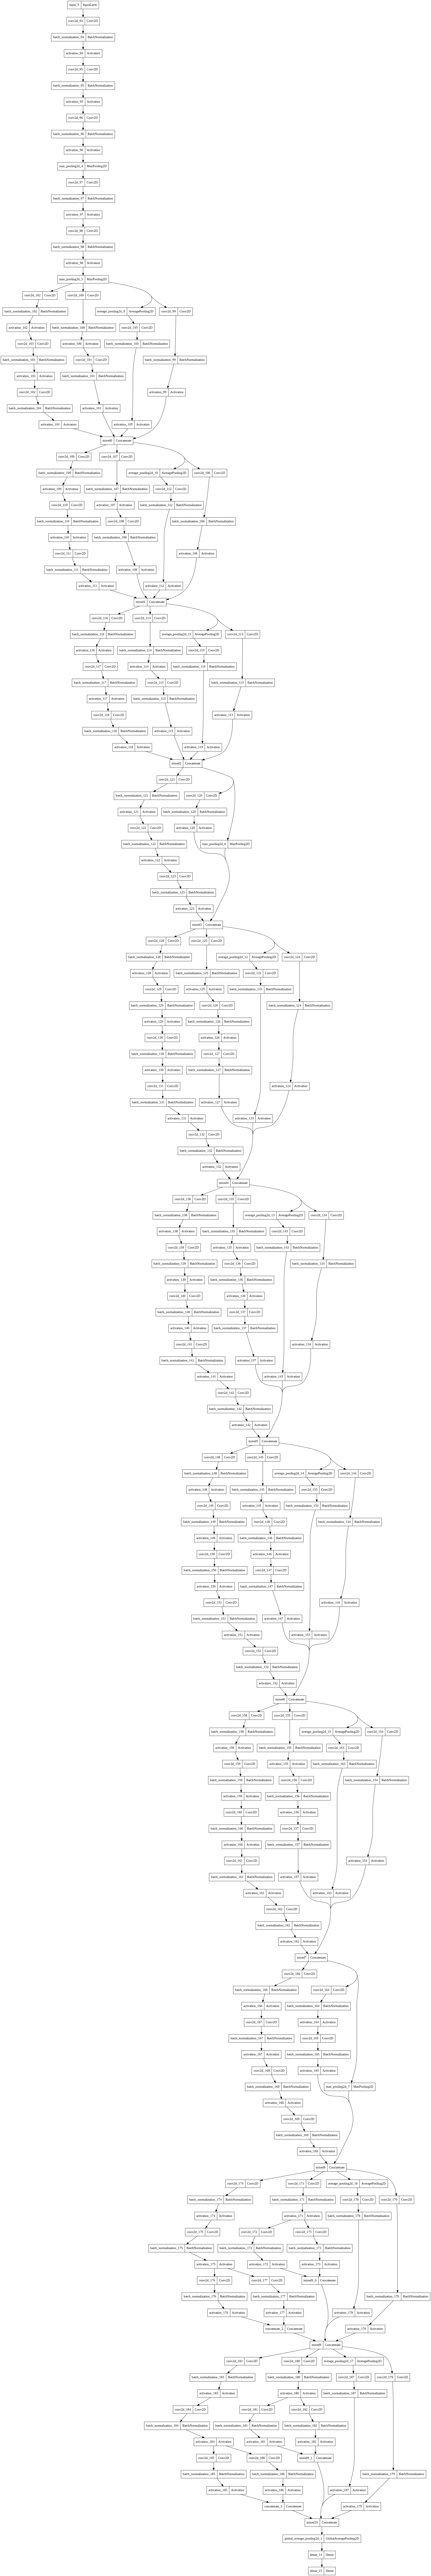

In [78]:
plot_model(model, to_file='model.png')